<a href="https://colab.research.google.com/github/angelmorales2621-gif/simulaci-n2/blob/main/Eventos_discretos_3_servidores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

ESTADÍSTICAS DE LA SIMULACIÓN M/M/3
Clientes Atendidos: 1198.000
Tiempo Promedio Espera: 0.225
Desviacion Espera: 0.370
Tiempo Maximo Espera: 1.798
Tiempo Promedio Sistema: 0.734
Longitud Promedio Cola: 0.893
Longitud Maxima Cola: 8.000
Utilizacion Servidores: 0.676


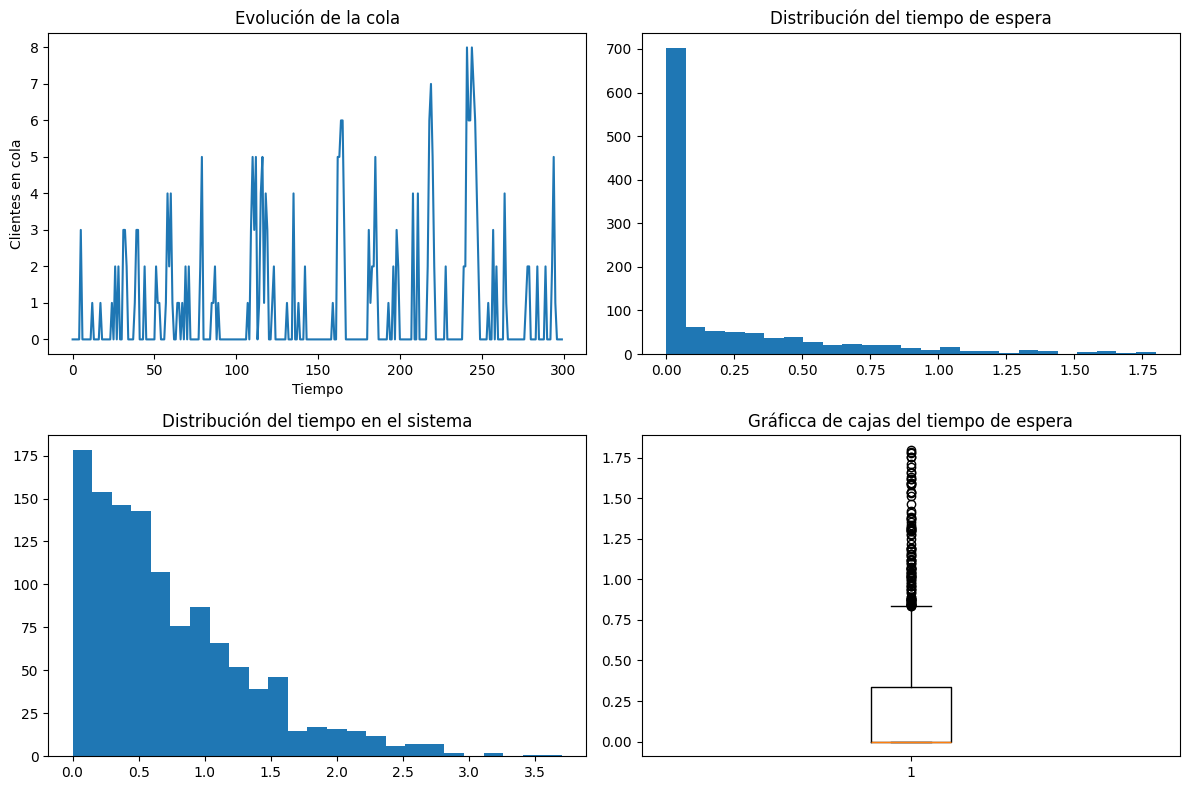

PERCENTILES DEL TIEMPO DE ESPERA
Percentil 50%: 0.00
Percentil 75%: 0.33
Percentil 90%: 0.77
Percentil 95%: 1.06
Percentil 99%: 1.59


In [3]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np


# PARÁMETROS DEL SISTEMA
TAZA_LLEGADAS = 4         # λ
TAZA_SERVICIO = 2         # μ
NUMERO_SERVIDORES = 3
TIEMPO_SIMULACION = 300


# VARIABLES
tiempos_espera = []
tiempos_sistema = []
longitudes_cola = []
puntos_tiempo = []
tiempo_ocupado = 0


# CLIENTES

def cliente(env, nombre, servidores):
    global tiempo_ocupado
    llegada = env.now

    with servidores.request() as req:
        yield req

        espera = env.now - llegada
        tiempos_espera.append(espera)

        servicio = random.expovariate(TAZA_SERVICIO)
        tiempo_ocupado += servicio
        yield env.timeout(servicio)

        tiempos_sistema.append(env.now - llegada)


# SISTEMA

def monitoreo(env, servidores):
    while True:
        longitudes_cola.append(len(servidores.queue))
        puntos_tiempo.append(env.now)
        yield env.timeout(1)


# GENERADOR DE CLIENTES

def generador_clientes(env, servidores):
    i = 0
    while True:
        i += 1
        env.process(cliente(env, f"Cliente_{i}", servidores))
        yield env.timeout(random.expovariate(TAZA_LLEGADAS))


# SIMULACIÓN

def ejecutar_simulacion():
    global tiempo_ocupado
    global tiempos_espera, tiempos_sistema, longitudes_cola, puntos_tiempo

    # Reiniciar variables
    tiempos_espera = []
    tiempos_sistema = []
    longitudes_cola = []
    puntos_tiempo = []
    tiempo_ocupado = 0

    env = simpy.Environment()
    servidores = simpy.Resource(env, capacity=NUMERO_SERVIDORES)

    env.process(generador_clientes(env, servidores))
    env.process(monitoreo(env, servidores))
    env.run(until=TIEMPO_SIMULACION)

# Ejecutar simulación
ejecutar_simulacion()


# ESTADÍSTICAS

def calcular_estadisticas():
    utilizacion = min(
        tiempo_ocupado / (NUMERO_SERVIDORES * TIEMPO_SIMULACION), 1
    )

    return {
        "clientes_atendidos": len(tiempos_espera),
        "tiempo_promedio_espera": statistics.mean(tiempos_espera),
        "desviacion_espera": statistics.stdev(tiempos_espera),
        "tiempo_maximo_espera": max(tiempos_espera),
        "tiempo_promedio_sistema": statistics.mean(tiempos_sistema),
        "longitud_promedio_cola": statistics.mean(longitudes_cola),
        "longitud_maxima_cola": max(longitudes_cola),
        "utilizacion_servidores": utilizacion
    }

estadisticas = calcular_estadisticas()


print("ESTADÍSTICAS DE LA SIMULACIÓN M/M/3")

for k, v in estadisticas.items():
    print(f"{k.replace('_',' ').title()}: {v:.3f}")



# GRÁFICAS

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(puntos_tiempo, longitudes_cola)
plt.title("Evolución de la cola")
plt.xlabel("Tiempo")
plt.ylabel("Clientes en cola")

plt.subplot(2, 2, 2)
plt.hist(tiempos_espera, bins=25)
plt.title("Distribución del tiempo de espera")

plt.subplot(2, 2, 3)
plt.hist(tiempos_sistema, bins=25)
plt.title("Distribución del tiempo en el sistema")

plt.subplot(2, 2, 4)
plt.boxplot(tiempos_espera, vert=True)
plt.title("Gráficca de cajas del tiempo de espera")

plt.tight_layout()
plt.show()


# PERCENTILES


print("PERCENTILES DEL TIEMPO DE ESPERA")


for p in [50, 75, 90, 95, 99]:
    print(f"Percentil {p}%: {np.percentile(tiempos_espera, p):.2f}")